# Predicting Daily PM2.5

In [263]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
root_dir = Path().absolute()

In [264]:
today = datetime.datetime.now() - datetime.timedelta(1)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 16, 33, 11, 76722)

In [265]:
project = hopsworks.login(project='akeelaf')
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

2025-11-17 16:33:11,086 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 16:33:11,088 INFO: Initializing external client
2025-11-17 16:33:11,089 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 16:33:12,401 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1277076


In [266]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=8,
)

fv = retrieved_model.get_feature_view()

saved_model_dir = retrieved_model.download()

2025-11-17 16:33:20,315 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/7989170 elapsed<00:00 remaining<?

%6|1763393605.038|FAIL|rdkafka#producer-15| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50131ms in state UP, 1 identical error(s) suppressed)


Downloading: 0.000%|          | 0/39396 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/71042 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/39395 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/47419 elapsed<00:00 remaining<?

In [267]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

retrieved_xgboost_model

XGBRegressor(base_score='4.407983E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'int', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [268]:
REGION = "west"
pm25_daily_fg = fs.get_feature_group(
    name="pm25_daily",
    version=4
)
wind_direction_daily_fg = fs.get_feature_group(
    name="wind_direction_daily",
    version=4
)

wind_speed_daily_fg = fs.get_feature_group(
    name="wind_speed_daily",
    version=4
)

air_temperature_daily_fg = fs.get_feature_group(
    name="air_temperature_daily",
    version=4
)

print("pm25_daily_fg:", "Loaded" if pm25_daily_fg is not None else "Not Loaded")
print("wind_direction_daily_fg:", "Loaded" if wind_direction_daily_fg is not None else "Not Loaded")
print("wind_speed_daily_fg:", "Loaded" if wind_speed_daily_fg is not None else "Not Loaded")
print("air_temperature_daily_fg:", "Loaded" if air_temperature_daily_fg is not None else "Not Loaded")

base_query = wind_direction_daily_fg.select_all().filter(wind_direction_daily_fg.timestamp >= today).filter(wind_direction_daily_fg.region == REGION)
joined_query = (
    base_query
    .join(wind_speed_daily_fg.select_all(), on=["timestamp", "region"])
    .join(air_temperature_daily_fg.select_all(), on=["timestamp", "region"])
)
future_weather = joined_query.read()
future_weather["timestamp"] = pd.to_datetime(future_weather["timestamp"])
future_weather = future_weather.sort_values("timestamp").reset_index(drop=True)

# keep only next 7 days
future_weather = future_weather.head(7)

%6|1763393609.998|FAIL|rdkafka#consumer-16| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 99973ms in state UP, 1 identical error(s) suppressed)
%6|1763393610.432|FAIL|rdkafka#consumer-16| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50110ms in state UP, 1 identical error(s) suppressed)


pm25_daily_fg: Loaded
wind_direction_daily_fg: Loaded
wind_speed_daily_fg: Loaded
air_temperature_daily_fg: Loaded
2025-11-17 16:33:31,500 WARNING: Ambiguous features detected during query construction.The feature `region` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `timestamp` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `latitude` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `longitude` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `day_of_week` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `day_of_month` is 

In [269]:
# 1) historical pm25 up to *yesterday*
hist_pm25 = (
    pm25_daily_fg
    .select(["region", "timestamp", "pm25"])
    .filter(pm25_daily_fg.region == REGION)
    .filter(pm25_daily_fg.timestamp < today)
    .read()
)

hist_pm25["timestamp"] = pd.to_datetime(hist_pm25["timestamp"])
hist_pm25 = hist_pm25.sort_values("timestamp").reset_index(drop=True)
hist_pm25

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


,region,timestamp,pm25
0,west,2014-01-29 00:00:00+00:00,53.0
1,west,2014-01-30 00:00:00+00:00,49.0
2,west,2014-01-31 00:00:00+00:00,53.0
3,west,2014-02-01 00:00:00+00:00,48.0
4,west,2014-02-02 00:00:00+00:00,54.0
...,...,...,...
4154,west,2025-11-12 00:00:00+00:00,52.0
4155,west,2025-11-13 00:00:00+00:00,66.0
4156,west,2025-11-14 00:00:00+00:00,45.0
4157,west,2025-11-15 00:00:00+00:00,37.0


In [270]:
from datetime import timedelta

import numpy as np


def forecast_next_n_days(model, hist_pm25, future_weather, n_days=7):
    """
    Recursive multi-step forecast:
    - hist_pm25: DataFrame with columns ['region','timestamp','pm25'] for past days
    - future_weather: DataFrame with 7 future rows (region, timestamp, weather features)
    - Returns forecast_df with ['region','timestamp','predicted_pm25']
    """
    booster = model.get_booster()
    model_features = booster.feature_names

    work_hist = hist_pm25.copy()

    forecasts = []

    lag_days = [1, 2, 3, 4, 5, 6, 7, 14, 28]
    rolling_windows = [3, 7, 14, 28]

    for i in range(min(n_days, len(future_weather))):
        row_weather = future_weather.loc[[i]].copy()
        ts = row_weather["timestamp"].iloc[0]

        for lag in lag_days:
            lag_ts = ts - timedelta(days=lag)
            match = work_hist[work_hist["timestamp"] == lag_ts]
            if len(match) == 0:
                val = np.nan
            else:
                val = match["pm25"].iloc[-1]
            row_weather[f"pm25_lag_{lag}d"] = val

        for window in rolling_windows:
            start_ts = ts - timedelta(days=window)
            mask = (work_hist["timestamp"] > start_ts) & (work_hist["timestamp"] <= ts - timedelta(days=1))
            window_vals = work_hist.loc[mask, "pm25"]

            row_weather[f"pm25_rolling_mean_{window}d"] = window_vals.mean() if not window_vals.empty else np.nan
            row_weather[f"pm25_rolling_min_{window}d"]  = window_vals.min()  if not window_vals.empty else np.nan
            row_weather[f"pm25_rolling_max_{window}d"]  = window_vals.max()  if not window_vals.empty else np.nan
            row_weather[f"pm25_rolling_std_{window}d"]  = window_vals.std()  if not window_vals.empty else np.nan

        ts_dt = pd.to_datetime(ts)
        row_weather["day_of_week"] = ts_dt.dayofweek
        row_weather["day_of_month"] = ts_dt.day
        row_weather["month"] = ts_dt.month
        row_weather["year"] = ts_dt.year
        row_weather["is_weekend"] = ts_dt.dayofweek >= 5

        for f in model_features:
            if f not in row_weather.columns:
                row_weather[f] = np.nan

        X = row_weather[model_features].astype(float)

        y_hat = model.predict(X)[0]

        forecasts.append({
            "region": row_weather["region"].iloc[0],
            "timestamp": ts,
            "days_before_forecast_day": i + 1,
            "predicted_pm25": y_hat,
        })

        work_hist = pd.concat([
            work_hist,
            pd.DataFrame([{"region": row_weather["region"].iloc[0], "timestamp": ts, "pm25": y_hat}])
        ], ignore_index=True)

    forecast_df = pd.DataFrame(forecasts).sort_values("timestamp").reset_index(drop=True)
    return forecast_df

In [271]:
hist_pm25 = (
    pm25_daily_fg
    .select(["region", "timestamp", "pm25"])
    .filter(pm25_daily_fg.region == REGION)
    .filter(pm25_daily_fg.timestamp < today)
    .read()
)

hist_pm25["timestamp"] = pd.to_datetime(hist_pm25["timestamp"])
hist_pm25 = hist_pm25.sort_values("timestamp").reset_index(drop=True)

future_weather = joined_query.read()
future_weather["timestamp"] = pd.to_datetime(future_weather["timestamp"])
future_weather = future_weather.sort_values("timestamp").reset_index(drop=True)
future_weather = future_weather.head(7)

forecast_7d = forecast_next_n_days(
    model=retrieved_xgboost_model,
    hist_pm25=hist_pm25,
    future_weather=future_weather,
    n_days=7,
)
forecast_7d

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 
2025-11-17 16:33:42,037 WARNING: Ambiguous features detected during query construction.The feature `region` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `timestamp` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `latitude` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `longitude` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `day_of_week` is present in feature groups ['air_temperature_daily version 4', 'wind_direction_daily version 4', 'wind_speed_daily version 4']. The feature `day_of_month` is present in feature groups ['a

,region,timestamp,days_before_forecast_day,predicted_pm25
0,west,2025-11-17 00:00:00+00:00,1,50.316326
1,west,2025-11-18 00:00:00+00:00,2,62.976524
2,west,2025-11-19 00:00:00+00:00,3,57.497093
3,west,2025-11-20 00:00:00+00:00,4,52.898727
4,west,2025-11-21 00:00:00+00:00,5,58.151646
5,west,2025-11-22 00:00:00+00:00,6,59.664196
6,west,2025-11-23 00:00:00+00:00,7,60.958393


In [272]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['timestamp']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

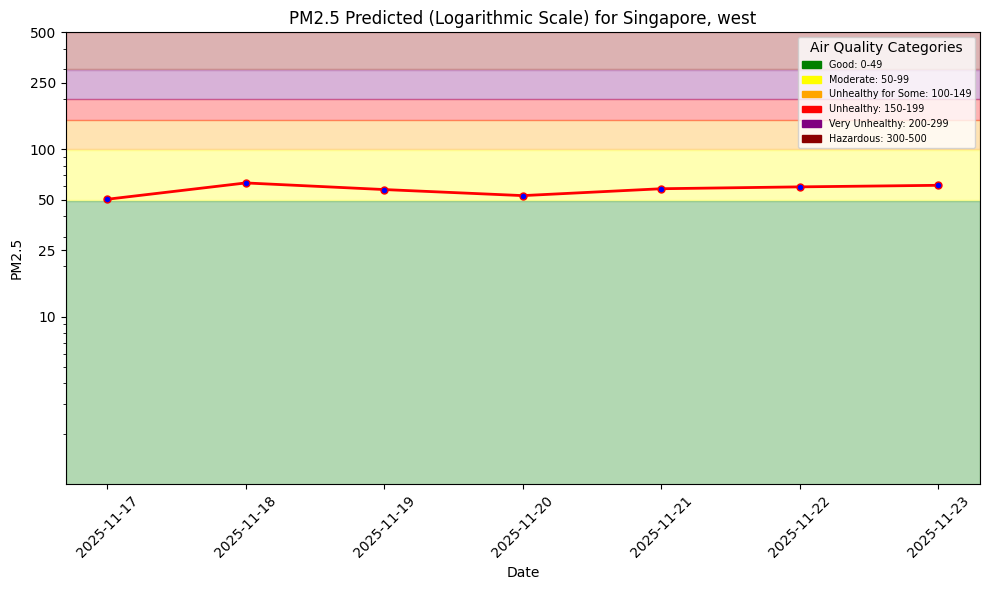

In [273]:
pred_file_path = f"{root_dir}/../air_quality_model/images/pm25_forecast.png"
plt = plot_air_quality_forecast('Singapore', REGION, forecast_7d, pred_file_path)
plt.show()

In [274]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=4,
    primary_key=['region','timestamp','days_before_forecast_day'],
    event_time="timestamp"
)
monitor_fg.insert(forecast_7d, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_4_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1277076/jobs/named/aq_predictions_4_offline_fg_materialization/executions
2025-11-17 16:34:05,142 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 16:34:11,530 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763393656.275|FAIL|rdkafka#producer-15| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50190ms in state UP, 1 identical error(s) suppressed)
%6|1763393660.906|FAIL|rdkafka#consumer-16| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50007ms in state UP, 1 identical error(s) suppressed)
%6|1763393661.095|FAIL|rdkafka#consumer-16| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50219ms in state UP, 1 identical error(s) suppressed)
%6|1763393711.781|FAIL|rdkafka#consumer-16| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50225ms in state UP, 1 identical error(s) suppressed)
%6|1763393752.004|FAIL|rdkafka#producer-15| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 94840ms in state UP, 1 identical error(s) suppressed)
%6|1763393761.894|FAIL|rdkafka#consumer-16| [thrd:ssl://51.161.80.189:9

2025-11-17 16:36:06,480 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 16:36:06,652 INFO: Waiting for log aggregation to finish.
2025-11-17 16:36:18,623 INFO: Execution finished successfully.


(Job('aq_predictions_4_offline_fg_materialization', 'SPARK'), None)

In [275]:
monitoring_df = monitor_fg.read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 


,region,timestamp,days_before_forecast_day,predicted_pm25
0,west,2025-11-19 00:00:00+00:00,4,57.330509
1,west,2025-11-17 00:00:00+00:00,2,61.899429
2,west,2025-11-20 00:00:00+00:00,5,52.631527
3,west,2025-11-22 00:00:00+00:00,7,62.256313
4,west,2025-11-21 00:00:00+00:00,6,58.752693
5,west,2025-11-16 00:00:00+00:00,1,65.234413
6,west,2025-11-18 00:00:00+00:00,3,60.507820
7,west,2025-11-21 00:00:00+00:00,5,58.151646
8,west,2025-11-18 00:00:00+00:00,2,62.976524
9,west,2025-11-20 00:00:00+00:00,4,52.898727


In [276]:
def backfill_predictions_for_monitoring(wind_direction_daily_fg, wind_speed_daily_fg, air_temperature_daily_fg, pm25_daily_fg, monitor_fg, model, region):
    # --- 1. Read feature groups from Hopsworks ---
    wd_df = wind_direction_daily_fg.read()   # region, timestamp, wind_direction_*
    ws_df = wind_speed_daily_fg.read()       # region, timestamp, wind_speed_*
    at_df = air_temperature_daily_fg.read()  # region, timestamp, air_temperature_*
    pm_df = pm25_daily_fg.read()             # region, timestamp, pm25 (+ lags/rollings)

    # --- 2. (Optional) filter by region ---
    if region is not None:
        wd_df = wd_df[wd_df["region"] == region]
        ws_df = ws_df[ws_df["region"] == region]
        at_df = at_df[at_df["region"] == region]
        pm_df = pm_df[pm_df["region"] == region]

    # --- 3. Join weather feature groups on (region, timestamp) ---
    # Assumes all three are region-daily, as you just implemented.
    weather_df = (
        wd_df
        .merge(ws_df, on=["region", "timestamp"], how="inner", suffixes=("", "_ws"))
        .merge(at_df, on=["region", "timestamp"], how="inner", suffixes=("", "_at"))
    )


    features_df = (
        weather_df
        .merge(pm_df, on=["region", "timestamp"], how="inner", suffixes=("", "_pm"))
    )
    features_df = features_df.sort_values(by=['timestamp'], ascending=True)
    features_df = features_df.tail(10)
    features_df['predicted_pm25'] = model.predict(features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, pm25_daily_fg[['timestamp','pm25','region']], on=["timestamp", "region"])
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df

In [277]:
pm25_daily_df = pm25_daily_fg.read()
outcome_df = pm25_daily_df[['timestamp', 'pm25', 'region']]
preds_df =  monitoring_df[['timestamp', 'predicted_pm25', 'region']]

hindcast_df = pd.merge(preds_df, outcome_df, on=["timestamp", "region"])
hindcast_df = hindcast_df.sort_values(by=['timestamp'])
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.29s) 


,timestamp,predicted_pm25,region,pm25
1,2025-11-16 00:00:00+00:00,65.234413,west,35.0
0,2025-11-17 00:00:00+00:00,61.899429,west,38.0
2,2025-11-17 00:00:00+00:00,50.316326,west,38.0


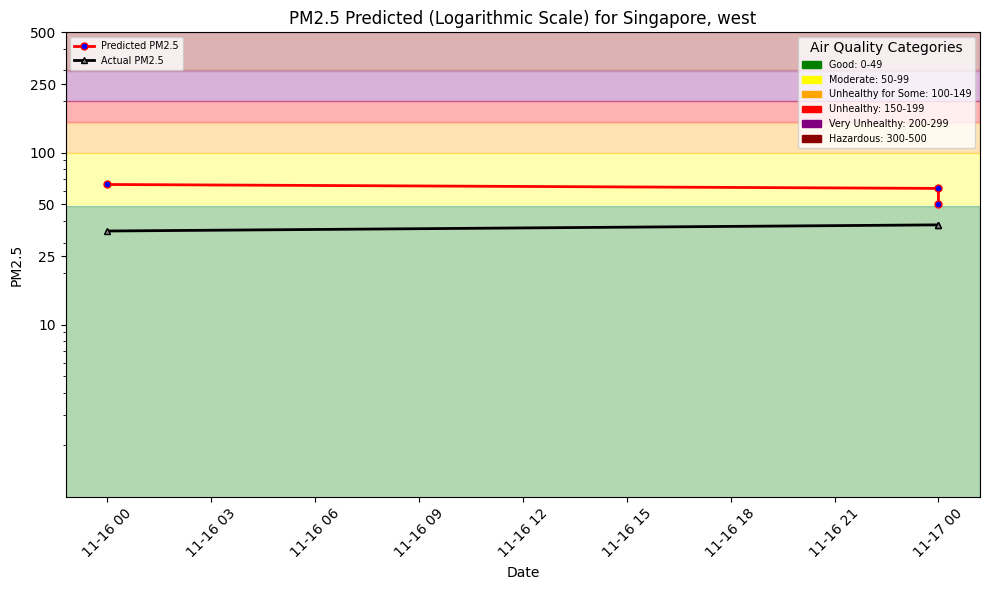

In [278]:
hindcast_path = f"{root_dir}/../air_quality_model/images/pm25_hindcast_1day.png"
plt = plot_air_quality_forecast('Singapore', REGION, hindcast_df, hindcast_path, hindcast=True)
plt.show()

In [279]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/singapore_{REGION}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_path, f"Resources/airquality/singapore_{REGION}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Volumes/Data/KTH/ML/air-quality-prediction/notebooks/../air_quality_model/images/pm25_forecast.png:…

Uploading /Volumes/Data/KTH/ML/air-quality-prediction/notebooks/../air_quality_model/images/pm25_hindcast_1day…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1277076/settings/fb/path/Resources/airquality


%6|1763393803.614|FAIL|rdkafka#producer-15| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50158ms in state UP, 1 identical error(s) suppressed)
%6|1763393812.811|FAIL|rdkafka#consumer-16| [thrd:GroupCoordinator]: GroupCoordinator: 51.161.81.208:9093: Disconnected (after 50002ms in state UP, 1 identical error(s) suppressed)
%6|1763393813.031|FAIL|rdkafka#consumer-16| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50227ms in state UP, 1 identical error(s) suppressed)
%6|1763393813.056|FAIL|rdkafka#consumer-16| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50115ms in state UP, 1 identical error(s) suppressed)
%6|1763393854.761|FAIL|rdkafka#producer-15| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50116ms in state UP, 1 identical error(s) suppressed)
%6|1763393863.007|FAIL|rdkafka#consumer-16| [thrd:ssl://51.161.